In [9]:
import jax.numpy as jnp
import jax
from jax import jit
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

# Model = namedtuple('Model', ['delta', 'alpha', 'beta'])
Model = namedtuple('Model', ['mu', 'lam'])
Params = namedtuple('Params', ['nx', 'nu', 'Q', 'R', 'Qf', 'Xref', 'tf', 'dt', 'N', 'model'])

nx = 2
nu = 1
Q = 0.5 * jnp.eye(nx)
R = 0.05 * jnp.eye(nu)
Qf = 1e2 * Q
Xref = jnp.array([0.0, 0.0])
tf = 5.0
dt = 0.05
N = int(tf / dt) + 1

model = Model(
    mu = -1.0,
    lam = 1.0,
)

params = Params(
    nx = nx,
    nu = nu,
    Q = Q,
    R = R,
    Qf = Qf,
    Xref = Xref,
    tf = tf,
    dt = dt,
    N = N,
    model = model,
)

print(params.dt)

0.05


In [10]:
def continuous_dynamics(x, u, params):
    x1, x2 = x[0], x[1]
   
    # xdot = jnp.array([
    #     x2,
    #     -params.model.delta * x2 - params.model.alpha * x1 - params.model.beta * x1**3 + u[0]
    # ])
    # xdot = jnp.array([
    #     x2,
    #     params.model.mu * (1 - x1**2) * x2 - x1 + u[0]
    # ])
    # xdot = jnp.array([
    #     jnp.sin(x1) + u[0],
    #     0.0,
    # ])
    xdot = jnp.array([
        params.model.mu * x1,
        params.model.lam * (x2 - x1**2) + u[0]
    ])

    return xdot

def rk4_step(x, u, params):
    k1 = params.dt*continuous_dynamics(x, u, params)
    k2 = params.dt*continuous_dynamics(x + k1/2, u, params)
    k3 = params.dt*continuous_dynamics(x + k2/2, u, params)
    k4 = params.dt*continuous_dynamics(x + k3, u, params)
    
    x_next = x + 1/6 * (k1 + 2*k2 + 2*k3 + k4)
    
    return x_next

def discrete_dynamics(x, u, params):
    return rk4_step(x, u, params)

# Dynamics derivatives
@jax.jit
def dfdx(x, u, params):
    return jax.jacobian(lambda x, u : discrete_dynamics(x, u, params), argnums=0)(x, u)

@jax.jit
def dfdu(x, u, params):
    return jax.jacobian(lambda x, u : discrete_dynamics(x, u, params), argnums=1)(x, u)

x = jnp.array([0.345, 1.0234])
u = jnp.array([1.4])

display(dfdx(x, u, params))
display(dfdu(x, u, params))

Array([[ 0.9512294 ,  0.        ],
       [-0.03367975,  1.0512711 ]], dtype=float32)

Array([[0.       ],
       [0.0512711]], dtype=float32)

In [11]:
def term_cost(x, params):
    xerr = x - params.Xref
    return 1/2 * jnp.dot(xerr, params.Qf @ xerr)

# Terminal cost derivatives
@jax.jit
def terminal_cost_expansion(x, params):
    J_x = jax.grad(lambda x: term_cost(x, params), argnums=0)(x)
    J_xx = jax.hessian(lambda x: term_cost(x, params), argnums=0)(x)

    return J_x, J_xx

In [12]:
J_x, J_xx = terminal_cost_expansion(x, params)
display(J_x)
display(J_xx)

Array([17.25, 51.17], dtype=float32)

Array([[50.,  0.],
       [ 0., 50.]], dtype=float32)

In [13]:
def stage_cost(x, u, params):
    xerr = x - params.Xref
    c1 = 1/2 * jnp.dot(xerr, params.Q @ xerr)
    c2 = 1/2 * jnp.dot(u, params.R @ u)
    return c1 + c2

@jax.jit
def stage_cost_expansion(x, u, params):
    J_x = jax.grad(lambda x, u: stage_cost(x, u, params), argnums=0)(x, u)
    J_u = jax.grad(lambda x, u: stage_cost(x, u, params), argnums=1)(x, u)
    J_xx = jax.hessian(lambda x, u: stage_cost(x, u, params), argnums=0)(x, u)
    J_uu = jax.hessian(lambda x, u: stage_cost(x, u, params), argnums=1)(x, u)
    J_xu = jax.jacobian(jax.grad(lambda x, u: stage_cost(x, u, params), argnums=0), argnums=1)(x, u)
    J_ux = J_xu.T
    
    return J_x, J_u, J_xx, J_uu, J_xu, J_ux

In [14]:
J_x, J_u, J_xx, J_uu, J_xu, J_ux = stage_cost_expansion(x, u, params)
display(J_x)
display(J_u)
display(J_xx)
display(J_uu)
display(J_xu)
display(J_ux)


Array([0.1725, 0.5117], dtype=float32)

Array([0.07], dtype=float32)

Array([[0.5, 0. ],
       [0. , 0.5]], dtype=float32)

Array([[0.05]], dtype=float32)

Array([[0.],
       [0.]], dtype=float32)

Array([[0., 0.]], dtype=float32)

In [15]:
def trajectory_cost(xbar, ubar, params):
    J = 0.0
    for i in range(N-1):
        Xi = xbar[i]
        Ui = ubar[i]
        J += stage_cost(Xi, Ui, params)
    
    J += term_cost(xbar[-1], params)
    return J

def backwards(xbar, ubar, regu, params):
    Xn = xbar[-1]
    V_x, V_xx = terminal_cost_expansion(Xn, params)
    
    ks = np.zeros((N, nu))
    Ks = np.zeros((N, nu, nx))
    
    delta_J = 0.0
    
    for i in range(N - 2, -1, -1):
        Xi = xbar[i]
        Ui = ubar[i]
                
        f_x, f_u = dfdx(Xi, Ui, params), dfdu(Xi, Ui, params)
        l_x, l_u, l_xx, l_uu, l_xu, l_ux = stage_cost_expansion(Xi, Ui, params)

        # Q_terms
        Q_x  = l_x  + f_x.T@V_x
        Q_u  = l_u  + f_u.T@V_x
        Q_xx = l_xx + f_x.T@V_xx@f_x
        Q_ux = l_ux + f_u.T@V_xx@f_x
        Q_uu = l_uu + f_u.T@V_xx@f_u

        # gains
        Q_uu_regu = Q_uu + regu * jnp.eye(nu)
        Q_uu_inv = np.linalg.inv(Q_uu_regu)

        k = -Q_uu_inv@Q_u
        K = -Q_uu_inv@Q_ux
        
        V_x  = Q_x + K.T@Q_u + Q_ux.T@k + K.T@Q_uu@k
        V_xx = Q_xx + 2*K.T@Q_ux + K.T@Q_uu@K
        
        ks[i] = k
        Ks[i] = K
        delta_J += Q_u.T@k + 0.5*k.T@Q_uu@k
    
    print(f"{delta_J=}")
    return ks, Ks, delta_J

def forwards(xbar, ubar, ds, Ks, alpha, params):
    xbar_new = np.zeros((N, nx))
    ubar_new = np.zeros((N-1, nu))
    xbar_new[0] = xbar[0]
        
    # for _ in range(max_iters):
    for k in range(N-1):
        ubar_new[k] = ubar[k] + alpha * ds[k] + Ks[k] @ (xbar_new[k] - xbar[k])
        xbar_new[k+1] = rk4_step(xbar_new[k], ubar_new[k], params)
    
    J = trajectory_cost(xbar_new, ubar_new, params)

    return xbar_new, ubar_new, J

def simulate(x0, ubar, params):
    xbar = np.zeros((N, nx))
    
    xbar[0] = x0
    for i in range(N-1):
        xbar[i+1] = rk4_step(xbar[i], ubar[i], params)
    
    return xbar, ubar

def iLQR(x0, uguess, params, atol=1e-3, max_iters=100, max_ls_iters=20):
    xbar, ubar = simulate(x0, uguess, params)
    
    for ilqr_iter in range(max_iters):
        Jold = trajectory_cost(xbar, ubar, params)
        alpha = 1.0
        
        ks, Ks, delta_J = backwards(xbar, ubar, 1e-3, params)
        xbar_new, ubar_new, J = forwards(xbar, ubar, ks, Ks, alpha, params)
        
        if np.abs(delta_J) < atol:
            print(f"Converged at iteration {ilqr_iter}")
            print(f"{J=}, {params.Xref=}, {xbar_new[-1]=}")
            return xbar_new, ubar_new, J
        
        for _ in range(max_ls_iters):
            if J < Jold:
                xbar = xbar_new
                ubar = ubar_new
                
                print(f"Line search succeeded at iteration {ilqr_iter=}, {alpha=}, {J=}")
                break
            
            alpha *= 0.5
            xbar_new, ubar_new, J = forwards(xbar, ubar, ks, Ks, alpha, params)
        else:
            raise RuntimeError(f"Line search failed at iteration {ilqr_iter}")
        

In [ ]:
nx = 2
nu = 1
Q = 0.5 * jnp.eye(nx)
R = 0.1 * jnp.eye(nu)
Qf = 1e2 * Q
Xref = jnp.array([0.0, 0.0])
tf = 8.0
dt = 0.05
N = int(tf / dt) + 1

model = Model(
    mu = -1.0,
    lam = 1.0,
)

params = Params(
    nx = nx,
    nu = nu,
    Q = Q,
    R = R,
    Qf = Qf,
    Xref = Xref,
    tf = tf,
    dt = dt,
    N = N,
    model = model,
)

ts = np.arange(0, params.tf + params.dt, params.dt)
uguess = np.ones((params.N-1, params.nu))

xs, us, Ks = iLQR(
    x0=jnp.array([5.0, -2.0]),
    uguess=uguess,
    params=params,
    atol=1e-3,
    max_iters=100,
    max_ls_iters=20,
)

delta_J=Array(-2.1193677e+10, dtype=float32)
Line search succeeded at iteration ilqr_iter=0, alpha=1.0, J=Array(305.90604, dtype=float32)
delta_J=Array(-0.01681815, dtype=float32)
Line search succeeded at iteration ilqr_iter=1, alpha=1.0, J=Array(305.8894, dtype=float32)
delta_J=Array(-7.0669006e-07, dtype=float32)
Converged at iteration 2
J=Array(305.88943, dtype=float32), params.Xref=Array([0., 0.], dtype=float32), xbar_new[-1]=array([ 1.67731335e-03, -2.55614054e-07])


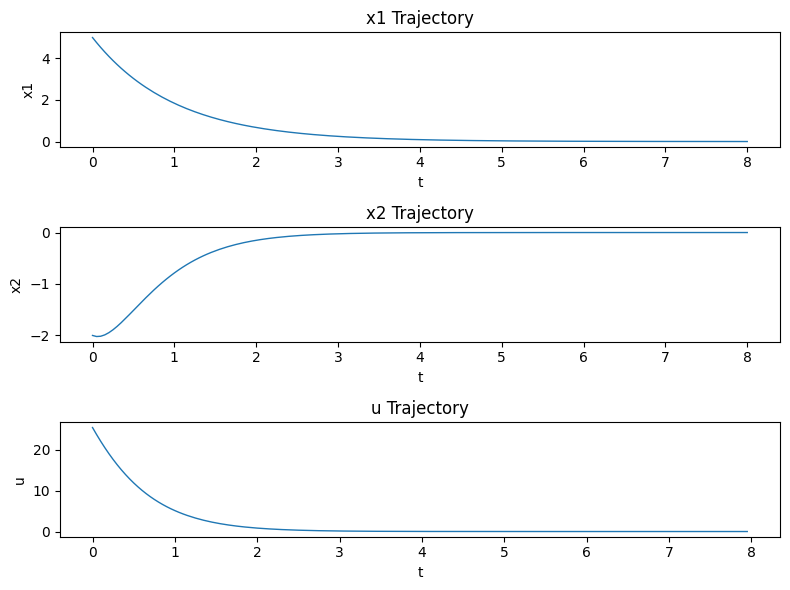

In [21]:
# Plot the trajectory
fig, ax = plt.subplots(3,1, figsize=(8, 6))

ax[0].plot(ts, xs[:, 0], label="x1", linewidth=1)
ax[1].plot(ts, xs[:, 1], label="x2", linewidth=1)
ax[2].plot(ts[:-1], us[:, 0], label="u", linewidth=1)

ax[0].set_title("x1 Trajectory")
ax[0].set_xlabel("t")
ax[0].set_ylabel("x1")

ax[1].set_title("x2 Trajectory")
ax[1].set_xlabel("t")
ax[1].set_ylabel("x2")

ax[2].set_title("u Trajectory")
ax[2].set_xlabel("t")
ax[2].set_ylabel("u")

plt.tight_layout()
plt.show()